# First Model for the Prediction of awake and sleep state

In [1]:
# Import needed libraries and packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

import random

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

RSEED=42


### Getting the Data into a dataframe

In [4]:
# Define the directory containing the files
data_directory = 'data/file_per_night'

If you already run the following cells and have the files 'train_data.parquet' and 'test_data.parque' in the 'data/file_per_night' directory, you can skip the following cells and continue with importing those two files into new dataframes.

In [ ]:
# Get a list of all files in the directory
file_paths = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, file))]

# Concatenate all dataframes into a single dataframe
dataframes = [pd.read_parquet(file) for file in file_paths]
full_dataframe = pd.concat(dataframes, ignore_index=True)

To have only two classes, we set the event 'onset' to 'awake' and 'wakeup' to 'sleep'

In [5]:
full_dataframe['event'].unique()

array(['awake', 'onset', 'sleep', 'wakeup'], dtype=object)

In [6]:
for i in full_dataframe.index:
    if full_dataframe['event'][i] == 'onset':
        full_dataframe['event'][i] = 'awake'
    elif full_dataframe['event'][i] == 'wakeup':
        full_dataframe['event'][i] = 'sleep'
    else:
        continue

### Remove Nas

In [ ]:
full_dataframe.isna().sum()

In [8]:
# remove Nas
full_dataframe.drop('night', axis = 1, inplace =True)
full_dataframe.dropna(inplace=True)

In [ ]:
# Check again
full_dataframe.isna().sum()

### Train / Test Split

Next, we perform the regular train-test-split, for training and evaluation of the model as usual:

In [10]:
# Split the data into train and test sets with stratification
train_data, test_data = train_test_split(full_dataframe, test_size=0.25, stratify=full_dataframe['event'], random_state=RSEED)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

Safe the train and test sets for later:

In [11]:
train_data.to_parquet(os.path.join(data_directory, "train_data.parquet"))
test_data.to_parquet(os.path.join(data_directory, "test_data.parquet"))

--> continue here, if you already created 'train_data.parque' and 'test_data.parquet'

In [12]:
# use this to read the train and test set, if they were already created
train_data = pd.read_parquet(os.path.join(data_directory, "train_data.parquet"))
test_data = pd.read_parquet(os.path.join(data_directory, "test_data.parquet"))

In [13]:
train_data.head()

,anglez,enmo,step,anglez_std,enmo_std,series_id,slope_enmo,slope_anglez,anglez_outside_45_counter,enmo_over_008_counter,...,enmo_10min_mean_shifted,enmo_10min_std_shifted,anglez_enmo_ratio,event,minutes_since_onset,year,month,day,hour,minute
0,-14.424609,0.003658,182597.5,4.746682,0.005972,d8de352c2657,-0.000151,-0.799072,0,3,...,0.000230,0.000024,-3942.945801,sleep,149.0,2018.0,6.0,22.0,1.0,51.0
1,26.503466,0.000475,125861.5,0.043014,0.000097,e1f5abb82285,0.000002,0.001565,0,0,...,0.001525,0.002136,55796.769531,sleep,123.0,2018.0,5.0,9.0,0.0,3.0
2,-18.044409,0.042500,152861.5,20.516253,0.018895,72bbd1ac3edf,-0.003736,1.039670,1,12,...,0.085963,0.056689,-424.574310,awake,722.0,2017.0,9.0,28.0,9.0,3.0
3,57.858017,0.001708,318041.5,0.348432,0.003356,e586cbfa7762,-0.000632,-0.045522,12,1,...,0.014827,0.018615,33868.105469,awake,0.0,2018.0,9.0,30.0,20.0,13.0
4,-22.259424,0.023200,183569.5,1.077463,0.006710,4743bdde25df,-0.001345,-0.134947,0,11,...,0.001198,0.002712,-959.457947,awake,420.0,2018.0,1.0,5.0,10.0,12.0


### Preprossesing

For the first model, we really want to start very basic. Therefore, we select only the features that were really given in the original dataset:

Feature Extraction

In [15]:
# Extract features and target variable from the data
X_train = train_data[['anglez', 'enmo']].reset_index(drop=True)
y_train = train_data['event'].reset_index(drop=True)

X_test = test_data[['anglez', 'enmo']].reset_index(drop=True)
y_test = test_data['event'].reset_index(drop=True)

Oversampling

In [16]:
# For oversampling (because we have more sleep than awake states), we apply SMOTE
smote = SMOTE(random_state=RSEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train= X_train_smote
y_train = y_train_smote

Scaling

In [18]:
# Initializing the scaler
scaler = MinMaxScaler()

# Scaling of features
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[5.1472121e-01, 3.0091999e-04],
       [6.1732268e-01, 5.7876552e-03],
       [2.9949349e-01, 8.6350953e-03],
       ...,
       [6.9295895e-01, 3.5682213e-04],
       [6.9211024e-01, 1.7864894e-03],
       [1.6076082e-01, 5.7971706e-03]], dtype=float32)

## Setting up and training of the model

Model type: Decision Tree

In [19]:
# Initializing the Classifier
model = DecisionTreeClassifier(random_state=RSEED, max_depth=10)

In [20]:
# Train the model on the training data
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [21]:
# Make predictions on the test data
y_pred = model.predict(X_test)

### Model Evaluation

In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 75.91%
Precision on test data: 75.84%
Recall on test data: 75.91%
F1 Score on test data: 75.84%


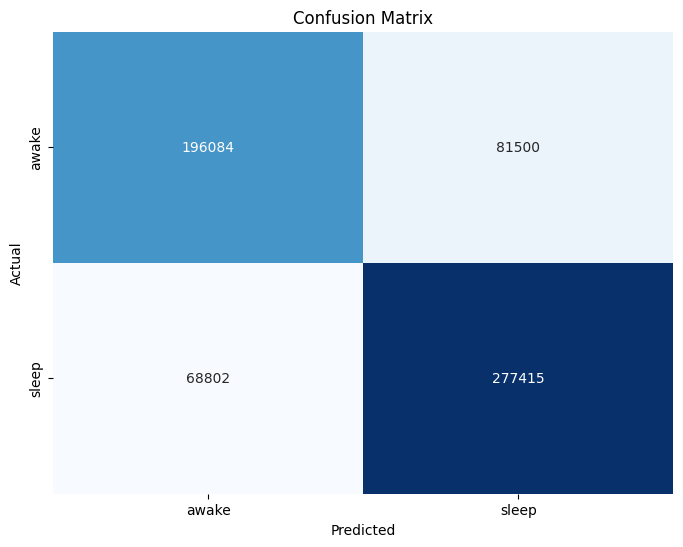

In [27]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.xticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.ylabel('Actual')
plt.yticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.title('Confusion Matrix')
plt.show()

Plot the decision tree model:

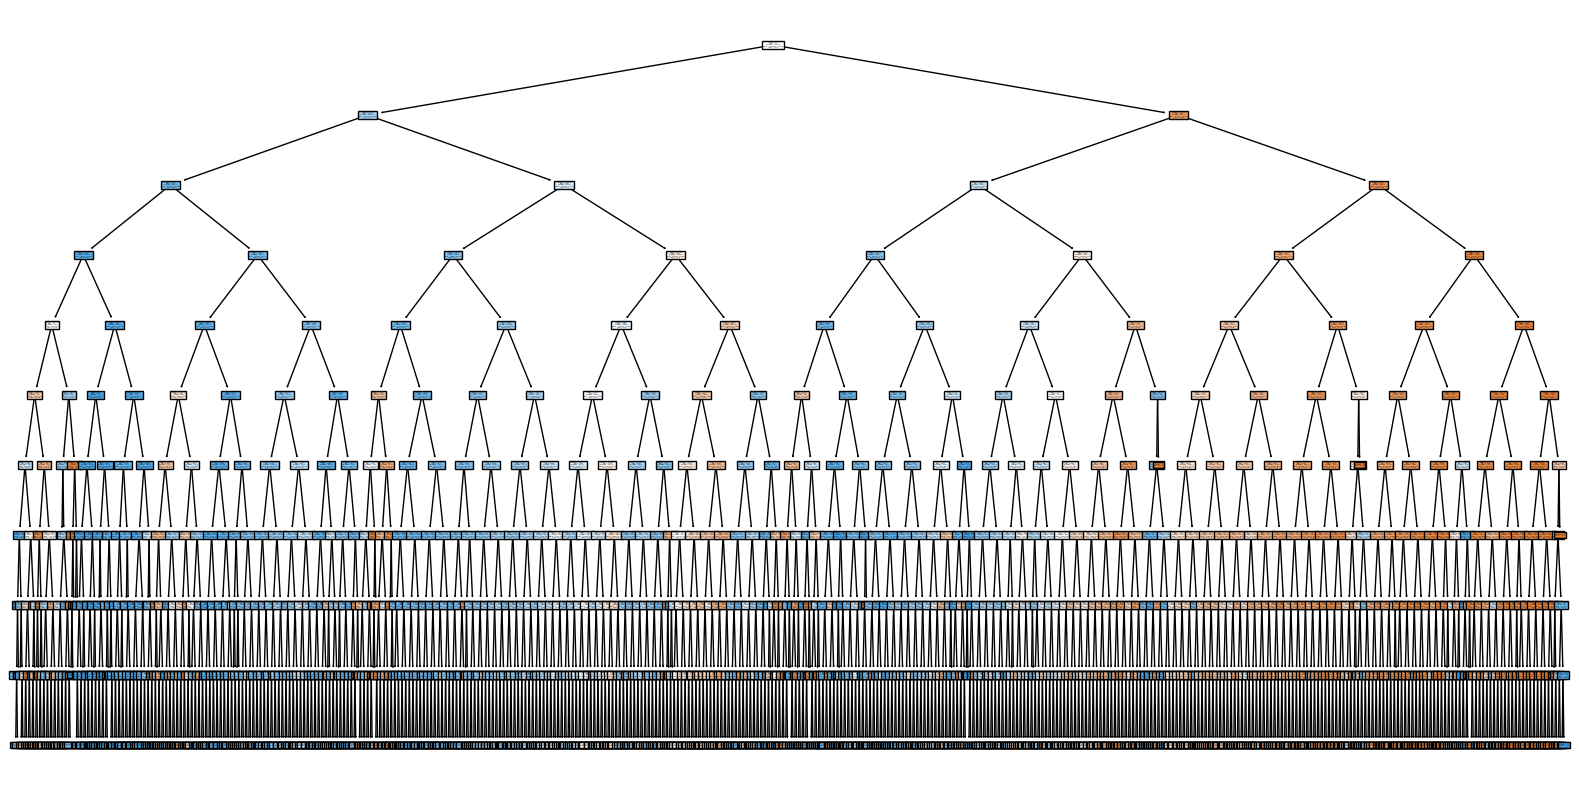

In [28]:
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=model.classes_)
plt.show()

## Grid Search

To find a better performing model, we perform a grid search testing different parameters:

In [29]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree Classifier
modelCV = DecisionTreeClassifier(random_state = RSEED)

In [30]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(modelCV, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 20]},
             scoring='accuracy')

In [31]:
# Print the best parameters and corresponding accuracy
best_params = grid_search.best_params_
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Accuracy: 0.7537218953027827


### Validation of best model

In [34]:
best_model = DecisionTreeClassifier(criterion= 'gini', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 10)

In [35]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_split=10)

In [37]:
y_pred_best = best_model.predict(X_test)

In [38]:
accuracy = accuracy_score(list(y_test), list(y_pred_best))
precision = precision_score(list(y_test), list(y_pred_best), average='weighted')
recall = recall_score(list(y_test), list(y_pred_best), average='weighted')
f1 = f1_score(list(y_test), list(y_pred_best), average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 75.44%
Precision on test data: 75.39%
Recall on test data: 75.44%
F1 Score on test data: 75.40%


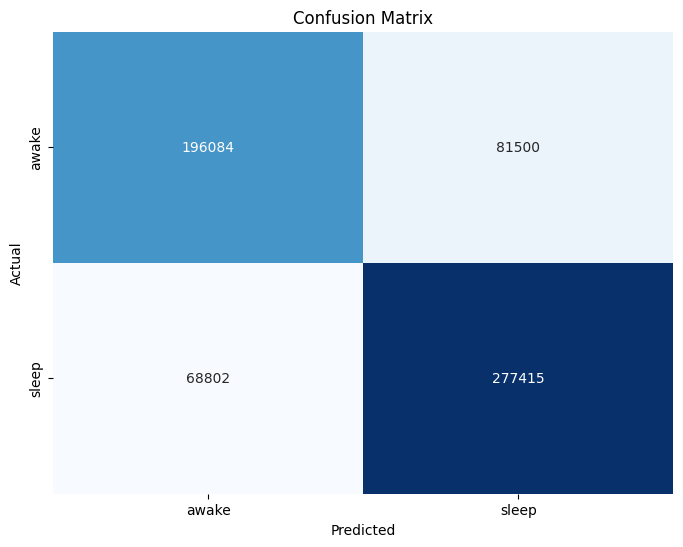

In [39]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.xticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.ylabel('Actual')
plt.yticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.title('Confusion Matrix')
plt.show()